In [242]:
import pandas as pd

In [243]:
from Bio import SeqIO

In [244]:
import ast

In [245]:
import numpy as np

# Novelty score
The goal of this score is to find sequences which have higher chance of producing a novel terpenes.
- If sequence comes from taxonomic unit without any characterized sequences, there is higher chance that the terpene could be new.
- If sequence comes from a SSN cluster where there are no characterized sequences (or only few), there is higher chance that the molecule could be new
    - and the bigger the cluster, the more interesting would be to study
- If sequence is in a big subtree without any char sequences, there is higher chance that the molecule could be new
- If sequence comes from a ESM network cluster where there are no characterized sequences (or only few), there is higher chance that the molecule could be new
- If it is in a cluster with characterized sequences, look if the characterized sequences produce interesting products
- Has a novel or less common architecture?


## Load the sequences

In [246]:
entries = []
with open("../../../02_mining/results/filtering/all_filtered_5_unique_no_stop.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        entries.append(record.id)

In [247]:
df = pd.DataFrame(entries, columns = ['id'])

In [248]:
df

,id
0,onekp_000000
1,onekp_000003
2,onekp_000004
3,onekp_000006
4,onekp_000007
...,...
606786,bfd_273443
606787,bfd_273498
606788,bfd_273500
606789,bfd_273502


In [249]:
df.shape

(606791, 1)

## Cluster information

In [250]:
cluster_df = pd.read_csv('../cluster_analysis/all_filtered_5_unique_no_stop_50_clstr_info.tsv', sep='\t', index_col=0)

In [251]:
cluster_df.shape

(21288, 36)

In [252]:
cluster_df['cluster_members'] = cluster_df['cluster_members'].apply(lambda x:  ast.literal_eval(x))

In [253]:
# Explode the df to get a sequence and its representative
cluster_df2 = cluster_df[['cluster_members', 'cluster_representative']].explode('cluster_members')

In [254]:
cluster_df2.shape

(606790, 2)

## Functions

In [255]:
def normalize(value, min_value, max_value):
    if max_value == min_value:
        return 0.0
    normalized_value = (value - min_value) / (max_value - min_value)
    return normalized_value

## TPS db

In [256]:
tps_db = '~//OneDrive//Dokumenty//Uni//Mgr//2.rocnik//diplomka//tps_db_analysis//data//tps_database_filtered_unique_product_and_domains.txt'

In [257]:
tps_db = pd.read_csv(tps_db, sep='\t')

In [258]:
tps_db['id'] = tps_db['id'].apply(lambda x: x.split()[0])

In [259]:
tps_db.shape

(1132, 28)

## Taxonomic novelty

If the sequence is from uncharacterized phylum, it gets 1. If it is from characterized specie or unknow/metagenomic, it gets 0.

In [260]:
tax_df = pd.read_csv('all_annotation_with_tax_score.csv', index_col=0)

C:\Users\terca\AppData\Local\Temp\ipykernel_17488\3502813402.py:1: DtypeWarning: Columns (8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  tax_df = pd.read_csv('all_annotation_with_tax_score.csv', index_col=0)


In [261]:
df = df.merge(tax_df[['id','tax_score']], how='left', on='id')

<Axes: ylabel='Frequency'>

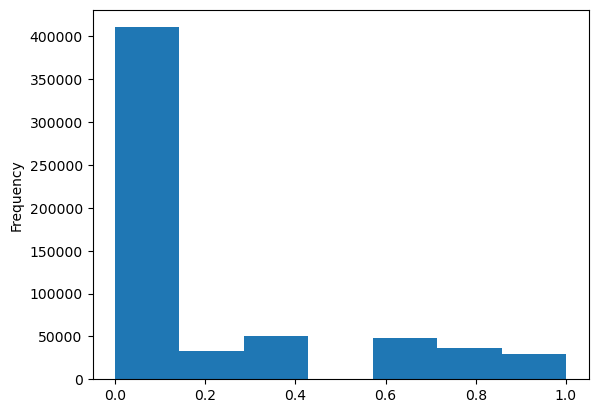

In [262]:
df['tax_score'].plot.hist(bins=7)

## Phylogenetic novelty

Each sequence corresponds to a leaf in a phylogenetic tree. For each leaf, we get the size (number of leaves) of largest possible clade consisting of only uncharacterized sequences. This number is then normalized to scale (0,1)

In [263]:
phylo_df = pd.read_csv('../phylogenetics/largest_unchar_clade_sizes.csv', names=['id','size'])

In [264]:
phylo_df

,id,size
0,uniprot_167215,5
1,uniprot_206481,5
2,uniprot_228221,5
3,mgnify_new_122346,5
4,uniprot_105362,5
...,...,...
22417,uniprot_202423,1973
22418,uniprot_229980,1973
22419,uniprot_243537,1973
22420,uniprot_186786,1973


<Axes: ylabel='Frequency'>

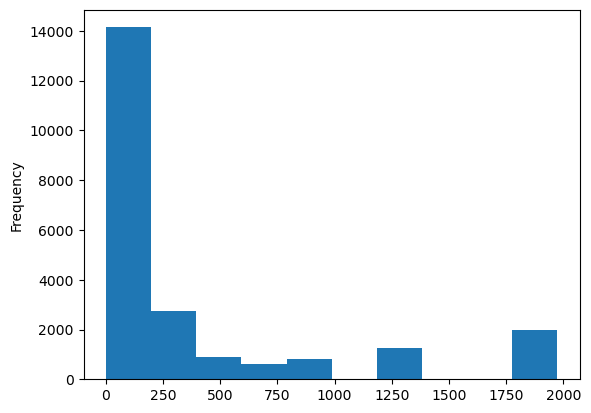

In [265]:
phylo_df['size'].plot.hist()

In [266]:
#phylo_m = phylo_df['size'].min()
#phylo_M = phylo_df['size'].max()

In [267]:
#phylo_df['size_norm'] = phylo_df['size'].apply(lambda x: normalize(x,phylo_m,phylo_M))

In [268]:
phylo_df['log_size'] = np.log(phylo_df['size'])

In [269]:
phylo_m = phylo_df['log_size'].min()
phylo_M = phylo_df['log_size'].max()

In [270]:
phylo_df

,id,size,log_size
0,uniprot_167215,5,1.609438
1,uniprot_206481,5,1.609438
2,uniprot_228221,5,1.609438
3,mgnify_new_122346,5,1.609438
4,uniprot_105362,5,1.609438
...,...,...,...
22417,uniprot_202423,1973,7.587311
22418,uniprot_229980,1973,7.587311
22419,uniprot_243537,1973,7.587311
22420,uniprot_186786,1973,7.587311


In [271]:
phylo_df['norm_log_size'] = phylo_df['log_size'].apply(lambda x: normalize(x,phylo_m,phylo_M))

In [272]:
phylo_df

,id,size,log_size,norm_log_size
0,uniprot_167215,5,1.609438,0.212122
1,uniprot_206481,5,1.609438,0.212122
2,uniprot_228221,5,1.609438,0.212122
3,mgnify_new_122346,5,1.609438,0.212122
4,uniprot_105362,5,1.609438,0.212122
...,...,...,...,...
22417,uniprot_202423,1973,7.587311,1.000000
22418,uniprot_229980,1973,7.587311,1.000000
22419,uniprot_243537,1973,7.587311,1.000000
22420,uniprot_186786,1973,7.587311,1.000000


### Add the size to all nodes
We have the clade size only for the representatives in the tree, we add this information for all sequences.

In [273]:
phylo_df2 = cluster_df2.merge(phylo_df, how='outer', left_on='cluster_representative', right_on='id', suffixes=[None,'_2'])

In [274]:
phylo_df2['id'] = phylo_df2.apply(lambda x: x['cluster_members'] if type(x['cluster_members'])==str else x['id'], axis=1)

In [275]:
phylo_df_final = phylo_df2[['id', 'norm_log_size']]

In [276]:
phylo_df_final

,id,norm_log_size
0,onekp_013169,0.663865
1,onekp_013222,0.663865
2,onekp_013240,0.663865
3,onekp_013241,0.663865
4,onekp_013247,0.663865
...,...,...
607919,P9WJ61,0.000000
607920,Q5NP67,0.000000
607921,Q6N3F1,0.000000
607922,RmTC-1,0.000000


In [277]:
df = df.merge(phylo_df_final, how='left', on='id')

In [278]:
df[df['tax_score'].isna()]

,id,tax_score,norm_log_size


In [279]:
df[df['norm_log_size'].isna()]

,id,tax_score,norm_log_size


## SSN cluster score

Give score which will be high for large clusters with little characterized sequences and low for small clusters with many characterized sequences.

In [280]:
ssn_cluster_df = pd.read_csv('cluster_info.csv', index_col=0)

In [281]:
ssn_cluster_df['unchar_perc'] = (ssn_cluster_df['total_size']-ssn_cluster_df['n_characterized'])/ssn_cluster_df['total_size']

<Axes: >

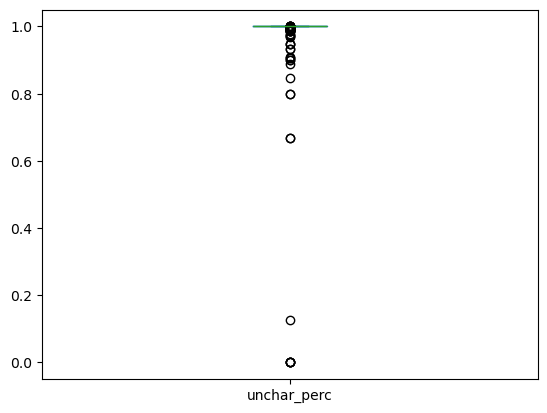

In [282]:
ssn_cluster_df['unchar_perc'].plot.box()

In [283]:
ssn_cluster_df['log_total_size'] = np.log(ssn_cluster_df['total_size'])

In [284]:
ssn_m = ssn_cluster_df['log_total_size'].min()
ssn_M = ssn_cluster_df['log_total_size'].max()

In [285]:
ssn_cluster_df['log_norm_total_size'] = ssn_cluster_df['log_total_size'].apply(lambda x: normalize(x, ssn_m, ssn_M))

<Axes: ylabel='Frequency'>

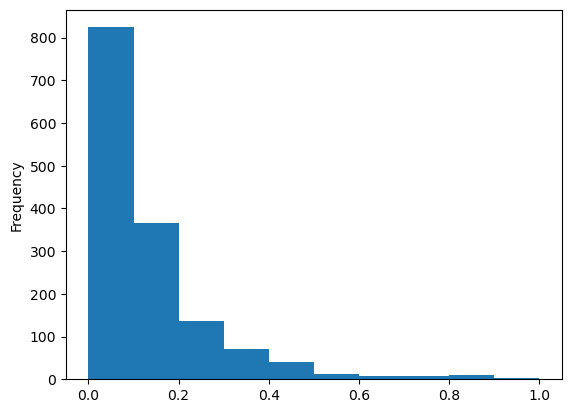

In [286]:
ssn_cluster_df['log_norm_total_size'].plot.hist()

<Axes: >

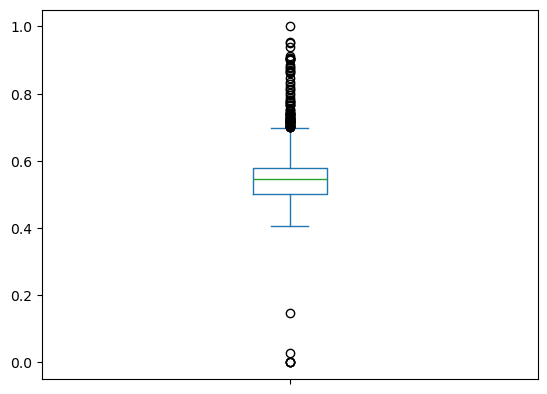

In [287]:
((ssn_cluster_df['unchar_perc'] + ssn_cluster_df['log_norm_total_size'])/2).plot.box()

In [288]:
ssn_cluster_df['cluster_score'] = (ssn_cluster_df['unchar_perc'] + ssn_cluster_df['log_norm_total_size'])/2

#### SSN cluster assignment

In [289]:
ssn_cluster_assignment_df = pd.read_csv('ssn_community_detection_cluster_assignment_all.csv', index_col=0)

In [290]:
ssn_cluster_df2 = ssn_cluster_assignment_df.merge(ssn_cluster_df[['cluster', 'cluster_score']], how='left', on='cluster')

In [291]:
ssn_cluster_df2 = ssn_cluster_df2.drop_duplicates()

In [292]:
df = df.merge(ssn_cluster_df2[['id','cluster_score']], how='left', on='id')

In [293]:
df[df['cluster_score'].isna()]

,id,tax_score,norm_log_size,cluster_score


## ESM score

## Product score

### Using sequence similarity

Get the product uniqness of the closest characterized sequence (based on sequence similarity).

In [294]:
closest_char_sequence_df = pd.read_csv('../reliability_score/all_filtered_5_most_similar.csv', names=['id','ss_closest_char_tps','ss'], sep=',')

In [295]:
product_df = closest_char_sequence_df.merge(tps_db[['id', 'most_unique_product_count']], how='left', left_on='ss_closest_char_tps', right_on='id', suffixes=[None,'_y'])[['id','most_unique_product_count']]

In [296]:
m = product_df['most_unique_product_count'].min()
M = product_df['most_unique_product_count'].max()

In [297]:
product_df

,id,most_unique_product_count
0,onekp_000000,12
1,onekp_000003,5
2,onekp_000004,3
3,onekp_000006,20
4,onekp_000007,3
...,...,...
606786,bfd_273443,12
606787,bfd_273498,1
606788,bfd_273500,1
606789,bfd_273502,21


In [298]:
product_df['product_score'] = product_df['most_unique_product_count'].apply(lambda x: 1-normalize(x,m,M))

In [299]:
df = df.merge(product_df[['id','product_score']], how='left', on='id')

In [300]:
df[df['product_score'].isna()]

,id,tax_score,norm_log_size,cluster_score,product_score


### Using embedding distance

In [301]:
esm_distances = pd.read_csv('../reliability_score/esm_min_distances_anno.csv', index_col=0)

In [302]:
esm_distances

,id,min_distance,closest_char_tps,closest_char_tps_id
0,mgnify_new_164215,1.307798,528,P21684
1,uniprot_159215,1.301663,528,P21684
2,bfd_207912,1.192460,1009,A0A7D0AGU9
3,mgnify_new_012702,0.930488,799,A0A0B4GN88
4,onekp_011005,0.547116,950,P08196
...,...,...,...,...
606786,bfd_268064,1.226685,528,P21684
606787,uniprot_068648,0.678793,909,Q9X839
606788,uniprot_256676,1.126783,1009,A0A7D0AGU9
606789,uniprot_035222,1.473279,560,G2P5T1


In [303]:
esm_product_df = esm_distances.merge(tps_db[['id', 'most_unique_product_count']], how='left', left_on='closest_char_tps_id', right_on='id', suffixes=[None,'_y'])

In [304]:
esm_product_df

,id,min_distance,closest_char_tps,closest_char_tps_id,id_y,most_unique_product_count
0,mgnify_new_164215,1.307798,528,P21684,P21684,2.0
1,uniprot_159215,1.301663,528,P21684,P21684,2.0
2,bfd_207912,1.192460,1009,A0A7D0AGU9,A0A7D0AGU9,21.0
3,mgnify_new_012702,0.930488,799,A0A0B4GN88,A0A0B4GN88,6.0
4,onekp_011005,0.547116,950,P08196,P08196,15.0
...,...,...,...,...,...,...
606786,bfd_268064,1.226685,528,P21684,P21684,2.0
606787,uniprot_068648,0.678793,909,Q9X839,Q9X839,1.0
606788,uniprot_256676,1.126783,1009,A0A7D0AGU9,A0A7D0AGU9,21.0
606789,uniprot_035222,1.473279,560,G2P5T1,G2P5T1,3.0


In [305]:
esm_product_m = esm_product_df['most_unique_product_count'].min()
esm_product_M = esm_product_df['most_unique_product_count'].max()

In [306]:
esm_product_df['product_score'] = esm_product_df['most_unique_product_count'].apply(lambda x: 1-normalize(x,esm_product_m,esm_product_M))

<Axes: ylabel='Frequency'>

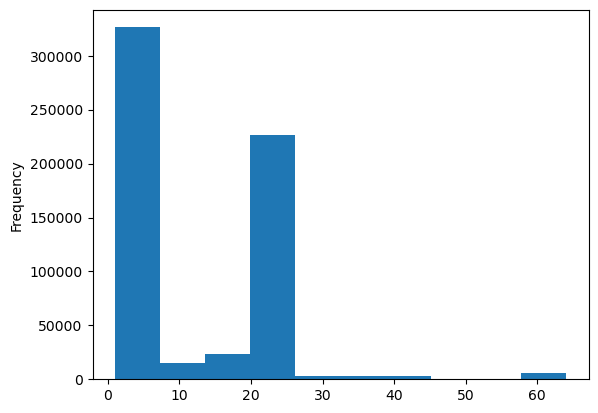

In [307]:
esm_product_df['most_unique_product_count'].plot.hist()

<Axes: ylabel='Frequency'>

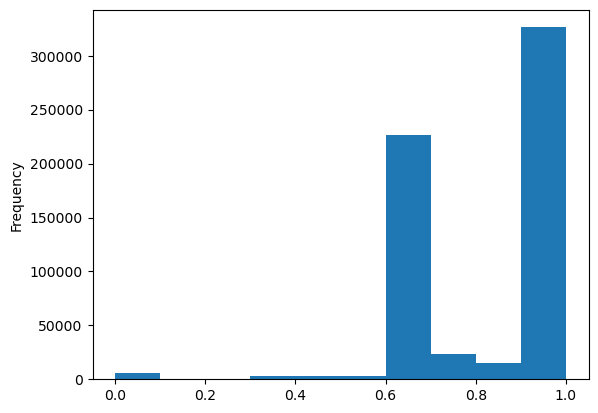

In [308]:
esm_product_df['product_score'].plot.hist()

## Total score

In [309]:
df['total_score'] = df['tax_score'] + df['norm_log_size'] + df['cluster_score'] + df['product_score']

<Axes: ylabel='Frequency'>

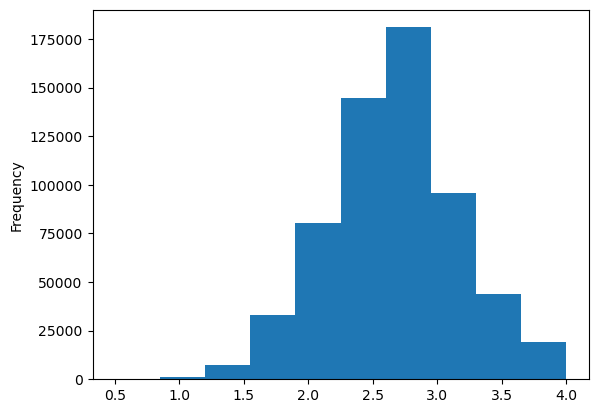

In [310]:
df['total_score'].plot.hist()

In [311]:
df.sort_values(by='total_score', ascending=False).head(30)

,id,tax_score,norm_log_size,cluster_score,product_score,total_score
232880,uniprot_221680,1.0,1.0,1.0,1.0,4.0
214879,uniprot_202730,1.0,1.0,1.0,1.0,4.0
248589,uniprot_238168,1.0,1.0,1.0,1.0,4.0
257472,uniprot_247414,1.0,1.0,1.0,1.0,4.0
244715,uniprot_234184,1.0,1.0,1.0,1.0,4.0
192813,uniprot_179805,1.0,1.0,1.0,1.0,4.0
257445,uniprot_247386,1.0,1.0,1.0,1.0,4.0
192875,uniprot_179869,1.0,1.0,1.0,1.0,4.0
192900,uniprot_179894,1.0,1.0,1.0,1.0,4.0
192907,uniprot_179901,1.0,1.0,1.0,1.0,4.0


In [312]:
df['id'].value_counts()

id
bfd_265998           4
onekp_000000         1
mgnify_new_166376    1
mgnify_new_166370    1
mgnify_new_166371    1
                    ..
uniprot_189590       1
uniprot_189591       1
uniprot_189592       1
uniprot_189593       1
bfd_273516           1
Name: count, Length: 606791, dtype: int64

In [313]:
df[df['id'] == 'bfd_265998']

,id,tax_score,norm_log_size,cluster_score,product_score,total_score
601149,bfd_265998,0.0,0.663865,0.911381,0.888889,2.464135
601150,bfd_265998,0.0,0.663865,0.901443,0.888889,2.454198
601151,bfd_265998,0.0,0.941626,0.911381,0.888889,2.741895
601152,bfd_265998,0.0,0.941626,0.901443,0.888889,2.731958


In [316]:
df.to_csv('novelty_score.csv')

# Test novelty score on characterized sequences

In [73]:
tax_tps_db = pd.read_csv('tpd_db_with_tax_info.csv', index_col=0)

In [74]:
tax_tps_db.shape

(2106, 32)

In [75]:
tax_tps_db['Uniprot ID'] = tax_tps_db['Uniprot ID'].apply(lambda x: x.split()[0])

In [76]:
tax_tps_db = tax_tps_db[['Uniprot ID','tax_id', 'lineage', 'genus', 'family', 'order',
       'class', 'phylum', 'kingdom', 'superkingdom', 'species']].drop_duplicates()

In [77]:
tps_db = tps_db.merge(tax_tps_db, how='left', left_on='id', right_on='Uniprot ID', suffixes=['_y', None])

In [78]:
tps_db

,id,name,type,type_general,species_y,kingdom_y,product_names,product_counts,most_unique_product_name,most_unique_product_count,...,tax_id,lineage,genus,family,order,class,phylum,kingdom,superkingdom,species
0,A0A023J8Z5,Delta guaiene synthase,sesq,sesq,Aquilaria microcarpa,Plantae,δ-guaiene; germacrene A; α-humulene,"[8, 6, 2]",α-humulene,2,...,690718,"{'species': 'Aquilaria microcarpa', 'genus': '...",Aquilaria,Thymelaeaceae,Malvales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Aquilaria microcarpa
1,A0A059PYD5,Caryophyllene synthase,mono,mono,Artemisia annua,Plantae,β-phellandrene,[13],β-phellandrene,13,...,35608,"{'species': 'Artemisia annua', 'genus': 'Artem...",Artemisia,Asteraceae,Asterales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Artemisia annua
2,A0A067SEC9,Sesquiterpene synthase GALMADRAFT_104215,sesq,sesq,Galerina marginata,Fungi,β-gurjunene,[1],β-gurjunene,1,...,109633,"{'species': 'Galerina marginata', 'genus': 'Ga...",Galerina,Strophariaceae,Agaricales,Agaricomycetes,Basidiomycota,Fungi,Eukaryota,Galerina marginata
3,A0A075FA51,"(+)-copalyl diphosphate synthase 3, chloroplastic",di-int,di,Marrubium vulgare,Plantae,"5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat...",[16],"5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat...",16,...,41230,"{'species': 'Marrubium vulgare', 'genus': 'Mar...",Marrubium,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Marrubium vulgare
4,A0A075FAK4,Peregrinol diphosphate synthase CPS1,di-int,di,Marrubium vulgare,Plantae,peregrinol diphosphate(3−),[2],peregrinol diphosphate(3−),2,...,41230,"{'species': 'Marrubium vulgare', 'genus': 'Mar...",Marrubium,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Marrubium vulgare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,X4ZWN5,Diterpene synthase TPS2,di-int,di,Plectranthus barbatus (C. forskohlii),Plantae,copal-8-ol diphosphate(3−),[8],copal-8-ol diphosphate(3−),8,...,41228,"{'species': 'Plectranthus barbatus', 'genus': ...",Plectranthus,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Plectranthus barbatus (C. forskohlii)
1128,X5A2Z7,Diterpene synthase TPS3,di,di,Plectranthus barbatus (C. forskohlii),Plantae,(13R)-Manoyl oxide,[3],(13R)-Manoyl oxide,3,...,41228,"{'species': 'Plectranthus barbatus', 'genus': ...",Plectranthus,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Plectranthus barbatus (C. forskohlii)
1129,X5A4D6,Diterpene synthase TPS1,di-int,di,Plectranthus barbatus (C. forskohlii),Plantae,(+)-copalyl diphosphate,[6],(+)-copalyl diphosphate,6,...,41228,"{'species': 'Plectranthus barbatus', 'genus': ...",Plectranthus,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Plectranthus barbatus (C. forskohlii)
1130,X5AHD9,Diterpene synthase TPS4,di,di,Plectranthus barbatus (C. forskohlii),Plantae,miltiradiene,[9],miltiradiene,9,...,41228,"{'species': 'Plectranthus barbatus', 'genus': ...",Plectranthus,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Plectranthus barbatus (C. forskohlii)


## Split the data into train and test

In [79]:
tps_db.shape

(1132, 39)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train, test = train_test_split(tps_db, random_state=42, test_size=0.2)

<Axes: xlabel='type_general'>

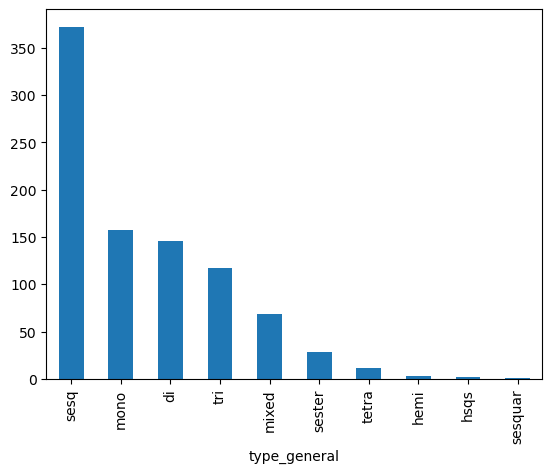

In [82]:
train['type_general'].value_counts().plot.bar()

<Axes: xlabel='type_general'>

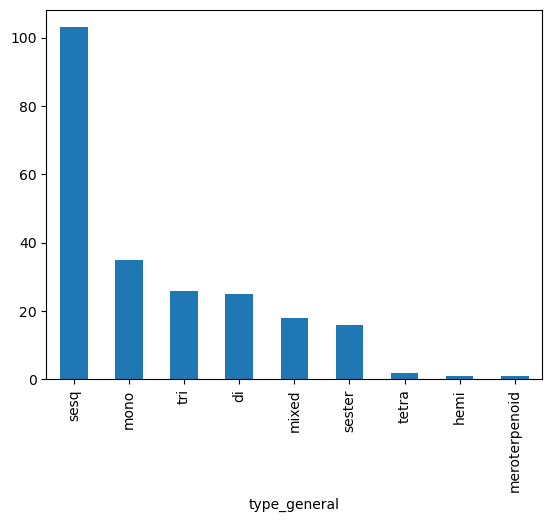

In [83]:
test['type_general'].value_counts().plot.bar()

<Axes: ylabel='Frequency'>

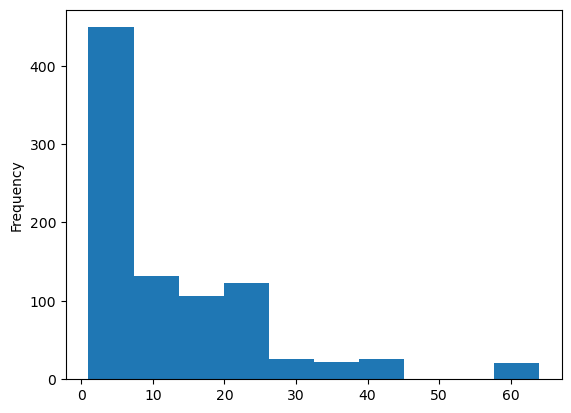

In [84]:
train['most_unique_product_count'].plot.hist()

<Axes: ylabel='Frequency'>

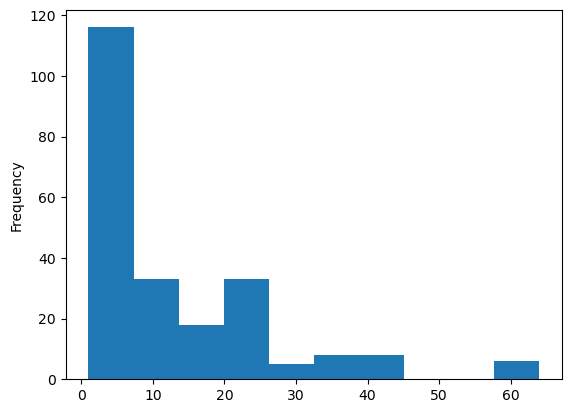

In [85]:
test['most_unique_product_count'].plot.hist()

<Axes: xlabel='superkingdom'>

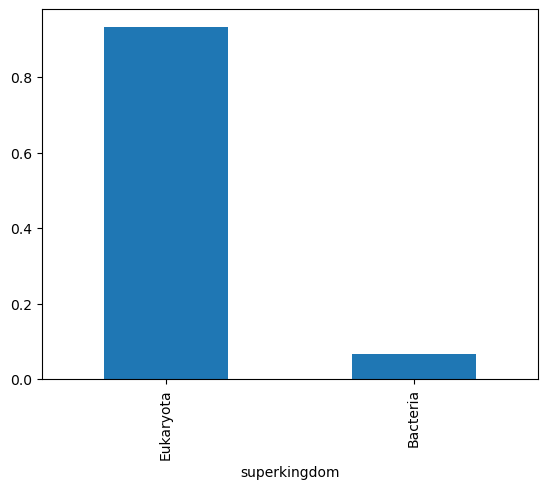

In [86]:
train['superkingdom'].value_counts(normalize=True).plot.bar()

<Axes: xlabel='superkingdom'>

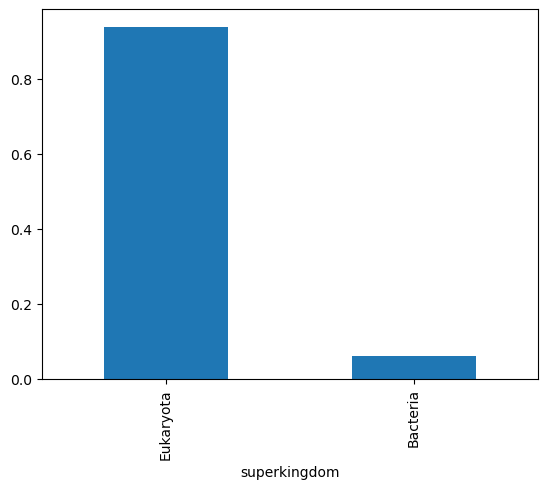

In [87]:
test['superkingdom'].value_counts(normalize=True).plot.bar()

In [88]:
test.columns

Index(['id', 'name', 'type', 'type_general', 'species_y', 'kingdom_y',
       'product_names', 'product_counts', 'most_unique_product_name',
       'most_unique_product_count', 'architecture_pfam', 'architecture_l_pfam',
       'PF06330.14', 'PF01397.24', 'PF03936.19', 'PF00494.22', 'PF13249.9',
       'PF19086.3', 'PF13243.9', 'architecture_supfam',
       'architecture_l_supfam', '0041184', '0053354', '0053355', '0048261',
       '0048806', '0046340', '0047573', 'Uniprot ID', 'tax_id', 'lineage',
       'genus', 'family', 'order', 'class', 'phylum', 'kingdom',
       'superkingdom', 'species'],
      dtype='object')

In [89]:
test = test[['id','tax_id','lineage','superkingdom']]

## Taxonomic novelty

In [90]:
def uncharacterized_tax_group(x, tax_group='phylum'):
    if type(x) == dict:
        value = x.get(tax_group, None)
        
        # The specie does not have the phylum information
        if value is None:
            return None
        
        # Check if there is characterized TPS from the same phylum 
        if value in train[tax_group].unique():
            return False
        else:
            return True
    else:
        return None

In [91]:
test['lineage'].iloc[0]

"{'species': 'Solanum lycopersicum', 'genus': 'Solanum', 'family': 'Solanaceae', 'order': 'Solanales', 'class': 'Magnoliopsida', 'phylum': 'Streptophyta', 'kingdom': 'Viridiplantae', 'superkingdom': 'Eukaryota'}"

In [92]:
test['lineage'] = test['lineage'].apply(lambda x: ast.literal_eval(x))

In [93]:
test['unchar_phylum'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'phylum'))

In [94]:
test['unchar_class'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'class'))

In [95]:
test['unchar_order'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'order'))

In [96]:
test['unchar_family'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'family'))

In [97]:
test['unchar_genus'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'genus'))

In [98]:
test['unchar_species'] = test['lineage'].apply(lambda x: uncharacterized_tax_group(x, 'species'))

In [99]:
def get_tax_score(x):
    if x['unchar_phylum'] == True:
        return 1
    elif x['unchar_class'] == True:
        return 0.8
    elif x['unchar_order'] == True:
        return 0.6
    elif x['unchar_family'] == True:
        return 0.4
    elif x['unchar_genus'] == True:
        return 0.2
    elif x['unchar_species'] == False:
        return 0
    elif x['superkingdom'] == 'Metagenome':
        return 0
    elif x['superkingdom'] == 'unknown':
        return 0
    elif x['unchar_species'] == True:
        return 0.1
    else:
        return 0

In [100]:
test['tax_score'] = test.apply(lambda x: get_tax_score(x), axis=1)

<Axes: ylabel='Frequency'>

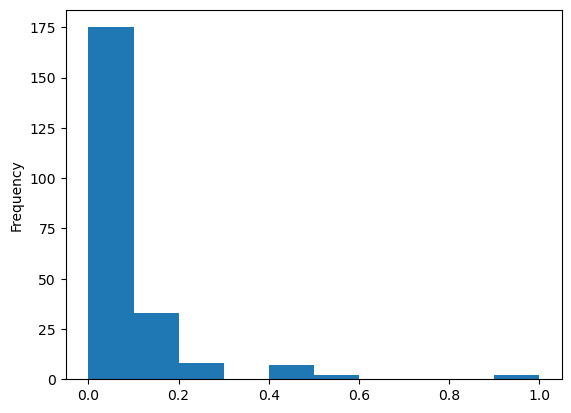

In [101]:
test['tax_score'].plot.hist()

## Phylogenetic novelty

In [102]:
from ete3 import Tree

In [103]:
tree = Tree('../phylogenetics/tree/clustalo/trimal_gt_80_cons_60/all_filtered_5_unique_no_stop_50_with_char_fastest.tree')

In [104]:
train

,id,name,type,type_general,species_y,kingdom_y,product_names,product_counts,most_unique_product_name,most_unique_product_count,...,tax_id,lineage,genus,family,order,class,phylum,kingdom,superkingdom,species
12,A0A076KZH5,Terpene synthase,sesq,sesq,Oryza barthii,Plantae,(−)-β-caryophyllene,[64],(−)-β-caryophyllene,64,...,65489,"{'species': 'Oryza barthii', 'genus': 'Oryza',...",Oryza,Poaceae,Poales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Oryza barthii
381,B9RHW5,Casbene synthase,di,di,Ricinus communis,Plantae,casbene,[2],casbene,2,...,3988,"{'species': 'Ricinus communis', 'genus': 'Rici...",Ricinus,Euphorbiaceae,Malpighiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Ricinus communis
717,P0CV94,"(3S,6E)-nerolidol synthase 1",sesq; mono,mixed,Fragaria ananassa,Plantae,"(3S,6E)-nerolidol; (S)-linalool","[5, 10]","(3S,6E)-nerolidol",5,...,3747,"{'species': 'Fragaria x ananassa', 'genus': 'F...",Fragaria,Rosaceae,Rosales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Fragaria ananassa
497,E3WDE2,Ent-kaurene synthase,di-int; di,mixed,Liochlaena subulata,Plantae,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat...","[21, 31]","5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat...",21,...,463575,"{'species': 'Liochlaena subulata', 'genus': 'L...",Liochlaena,Jungermanniaceae,Jungermanniales,Jungermanniopsida,Streptophyta,Viridiplantae,Eukaryota,Liochlaena subulata
964,Q8W3Z2,Lupeol synthase,tri,tri,Betula platyphylla,Plantae,lupeol,[14],lupeol,14,...,78630,"{'species': 'Betula platyphylla', 'genus': 'Be...",Betula,Betulaceae,Fagales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Betula platyphylla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,A0A1N7T9S7,(+)-delta-cadinene synthase,sesq,sesq,Gossypium hirsutum,Plantae,(+)-δ-cadinene,[20],(+)-δ-cadinene,20,...,3635,"{'species': 'Gossypium hirsutum', 'genus': 'Go...",Gossypium,Malvaceae,Malvales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Gossypium hirsutum
1044,R4I3I0,5-epi-aristolochene synthase,sesq,sesq,Nicotiana tabacum,Plantae,(+)-5-epi-aristolochene,[9],(+)-5-epi-aristolochene,9,...,4097,"{'species': 'Nicotiana tabacum', 'genus': 'Nic...",Nicotiana,Solanaceae,Solanales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Nicotiana tabacum
1095,T1RRS0,Germacrene A,sesq,sesq,Lavandula stoechas,Plantae,(−)-germacrene A; (−)-β-elemene,"[24, 26]",(−)-germacrene A,24,...,39333,"{'species': 'Lavandula stoechas', 'genus': 'La...",Lavandula,Lamiaceae,Lamiales,Magnoliopsida,Streptophyta,Viridiplantae,Eukaryota,Lavandula stoechas
860,Q675L0,Longifolene synthase,sesq,sesq,Picea abies,Plantae,longifolene,[5],longifolene,5,...,3329,"{'species': 'Picea abies', 'genus': 'Picea', '...",Picea,Pinaceae,Pinales,Pinopsida,Streptophyta,Viridiplantae,Eukaryota,Picea abies


In [105]:
characterized_leaves_ids = set(train['id'].tolist())

In [106]:
uncharacterized_leaves_ids = set(test['id'].tolist())

In [107]:
def get_largest_unchar_clade_size(leaf, characterized_leaves_ids=characterized_leaves_ids):
    largest_unchar_clade_size = 1
    for ancestor in leaf.iter_ancestors():
        leaves = set(ancestor.get_leaf_names())
        intersection = leaves.intersection(characterized_leaves_ids)
        if len(intersection) > 0:
            return largest_unchar_clade_size
        largest_unchar_clade_size = len(leaves)

In [108]:
uncharacterized_leaves = [leaf for leaf in tree.get_leaves() if leaf.name in uncharacterized_leaves_ids]

In [109]:
sizes = dict()
for leaf in uncharacterized_leaves:
    sizes[leaf.name] = get_largest_unchar_clade_size(leaf)

In [110]:
sizes_df = pd.DataFrame.from_dict(sizes, orient='index', columns=['size'])

<Axes: >

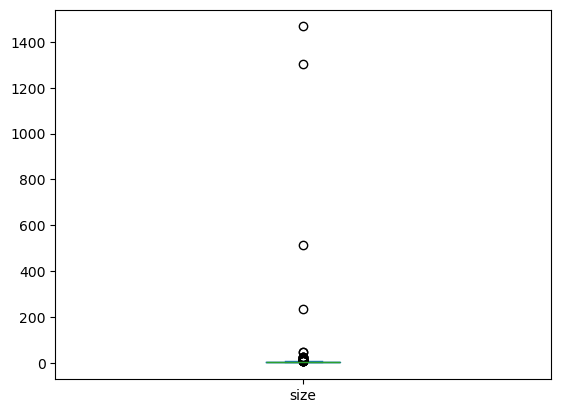

In [111]:
sizes_df['size'].plot.box()

In [112]:
test = test.merge(sizes_df, how='left', left_on='id', right_index=True, suffixes=[None,'_y'])

In [113]:
test['log_size'] = np.log(test['size'])

In [114]:
test['norm_log_size'] = test['log_size'].apply(lambda x: normalize(x,phylo_m,phylo_M))

## SSN cluster score

In [115]:
# Clustering clusters
cluster_info = '../cluster_analysis/all_filtered_5_unique_no_stop_50_clstr_info.tsv'
cluster_info_df = pd.read_csv(cluster_info, sep='\t', index_col=0)

In [116]:
cluster_info_df['cluster_members'] = cluster_info_df['cluster_members'].apply(lambda x:  ast.literal_eval(x))

In [117]:
# Community detection clusters
ssn_cluster_assignment_df = pd.read_csv('ssn_community_detection_cluster_assignment_all.csv', index_col=0)

In [118]:
cluster_df = pd.DataFrame(ssn_cluster_assignment_df['cluster'].value_counts())

In [119]:
cluster_df = cluster_df.rename(columns={'count': 'total_size'})

In [120]:
cluster_df = cluster_df.reset_index()

In [121]:
characterized_ids = train['id'].tolist()

In [122]:
n_characterized_df = pd.DataFrame(ssn_cluster_assignment_df.groupby('cluster')['id'].apply(lambda x: x.isin(characterized_ids).sum()))

In [123]:
n_characterized_df = n_characterized_df.rename(columns={'id': 'n_characterized'})

In [124]:
cluster_df = cluster_df.merge(n_characterized_df, how='left', left_on='cluster', right_index=True)

In [125]:
cluster_df

,cluster,total_size,n_characterized
0,19,198583,0
1,7,61590,0
2,110,57904,0
3,4,44342,10
4,18,22853,0
...,...,...,...
1470,931,1,0
1471,932,1,0
1472,933,1,0
1473,936,1,0


In [126]:
cluster_df['n_characterized'].sum()

905

In [127]:
test = test.merge(ssn_cluster_assignment_df, how='left', on='id')

In [128]:
test = test.merge(cluster_df, how='left', on='cluster')

<Axes: ylabel='Frequency'>

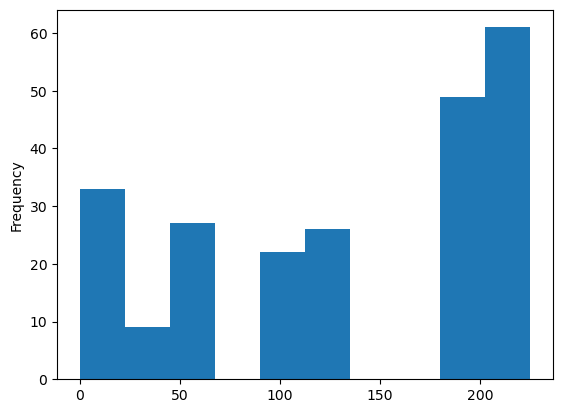

In [129]:
test['n_characterized'].plot.hist()

In [130]:
#test[test['n_characterized']<10]['most_unique_product_count'].mean()

In [131]:
#test[test['n_characterized']>10]['most_unique_product_count'].mean()

In [132]:
test['unchar_perc'] = (test['total_size']-test['n_characterized'])/test['total_size']

In [133]:
test['log_total_size'] = np.log(test['total_size'])

In [134]:
test['log_norm_total_size'] = test['log_total_size'].apply(lambda x: normalize(x, ssn_m, ssn_M))

In [135]:
test['cluster_score'] = (test['unchar_perc'] + test['log_norm_total_size'])/2

## Product score

In [136]:
# TODO: find closest char (train) sequence by embedding and get its product score

In [137]:
embeddings_dir = '../../../tps_db_analysis/esm/ems_embeddings_esm2_t6_8M_UR50D'

In [138]:
import torch

In [139]:
import os

In [140]:
import numpy as np

In [141]:
file_list = os.listdir(embeddings_dir)

n_files = len(file_list)
print(n_files)

1132


In [142]:
train_emb = []
train_names = []
test_emb = []
test_names = []
for i, esm_file in enumerate(file_list):
    seq_name = esm_file.split('.pt')[0]
    embs = torch.load(f'{embeddings_dir}/{esm_file}')
    if seq_name in train['id'].tolist():
        train_emb.append(embs['mean_representations'][6])
        train_names.append(seq_name)
    elif seq_name in test['id'].tolist():
        test_emb.append(embs['mean_representations'][6])
        test_names.append(seq_name)

In [143]:
train_emb2 = torch.stack(train_emb, dim=0).numpy()
train_emb_df = pd.DataFrame(train_emb2)
train_emb_df.index = train_names
train_emb_df.to_csv('train_embeddings.csv')

In [144]:
test_emb2 = torch.stack(test_emb, dim=0).numpy()
test_emb_df = pd.DataFrame(test_emb2)
test_emb_df.index = test_names
test_emb_df.to_csv('test_embeddings.csv')

In [145]:
chunk_size = 100

In [146]:
# Calculate pairwise Euclidean distances using chunking
min_distances = []
min_indices = []
for i in range(0, len(test_emb_df), chunk_size):
    chunk_test = test_emb_df.iloc[i:i+chunk_size]
    distances_chunk = np.linalg.norm(chunk_test.values[:, np.newaxis, :] - train_emb_df.values, axis=2)
    min_indices_chunk = np.argmin(distances_chunk, axis=1)
    min_distances_chunk = distances_chunk[np.arange(len(chunk_test)), min_indices_chunk]
    min_indices.extend(min_indices_chunk)
    min_distances.extend(min_distances_chunk)

In [147]:
min_distances

[0.38895145,
 0.45756978,
 0.34025237,
 0.15649875,
 0.7825226,
 0.09435787,
 0.26129597,
 0.50766283,
 0.5427054,
 0.3250096,
 0.11554131,
 0.27688468,
 0.5257462,
 0.06644474,
 0.5467453,
 0.4589347,
 0.8670586,
 0.55660015,
 0.849257,
 0.03946443,
 0.5322875,
 0.23330107,
 0.81214625,
 0.6783467,
 0.6629939,
 0.4505625,
 0.5880332,
 0.09135711,
 0.553441,
 0.5134697,
 0.5606652,
 0.6626214,
 0.16397485,
 0.16436465,
 0.2972274,
 0.4476512,
 0.48752108,
 0.7426141,
 0.03498499,
 0.5505576,
 0.47787365,
 0.68556595,
 0.10402344,
 0.5464805,
 0.70072913,
 0.4782246,
 0.58116645,
 0.08404372,
 0.6010302,
 0.49587813,
 0.5257462,
 0.4998072,
 0.103263795,
 0.36585364,
 0.0,
 0.21364665,
 0.4695255,
 0.0,
 0.7035882,
 0.48825014,
 0.53447884,
 0.55205363,
 0.4890648,
 0.5734219,
 0.25152895,
 0.23330642,
 0.5485928,
 0.18996845,
 0.05686055,
 0.3316912,
 0.51601,
 0.78694206,
 0.7168472,
 0.8319312,
 0.040692665,
 0.08539764,
 0.7372545,
 0.42098105,
 0.57571965,
 0.47497258,
 0.05592264,

In [148]:
# Create DataFrame to store results
result_df = pd.DataFrame({'id': test_emb_df.index, 'min_distance': min_distances, 'closest_char_tps': min_indices})

In [149]:
result_df

,id,min_distance,closest_char_tps
0,A0A075FA51,0.388951,902
1,A0A076GAU9,0.457570,671
2,A0A0A7DNH6,0.340252,880
3,A0A0B5KP67,0.156499,19
4,A0A0C3FBR2,0.782523,2
...,...,...,...
222,T2HPZ3,0.237778,1
223,UTU07507,0.411079,659
224,W8QMF8,0.381558,339
225,WDE20680.1,0.572577,895


In [150]:
result_df['closest_char_tps_name'] = result_df['closest_char_tps'].apply(lambda x: train_emb_df.index[x])

In [151]:
test_esm_product_df = result_df.merge(tps_db[['id', 'most_unique_product_count']], how='left', left_on='closest_char_tps_name', right_on='id', suffixes=[None,'_y'])

In [152]:
test_esm_product_df

,id,min_distance,closest_char_tps,closest_char_tps_name,id_y,most_unique_product_count
0,A0A075FA51,0.388951,902,X5A4D6,X5A4D6,6
1,A0A076GAU9,0.457570,671,Q64K29,Q64K29,24
2,A0A0A7DNH6,0.340252,880,U5N0S4,U5N0S4,20
3,A0A0B5KP67,0.156499,19,A0A0A0RDR2,A0A0A0RDR2,5
4,A0A0C3FBR2,0.782523,2,A0A067SEC9,A0A067SEC9,1
...,...,...,...,...,...,...
222,T2HPZ3,0.237778,1,A0A059PYD5,A0A059PYD5,13
223,UTU07507,0.411079,659,Q5D7Q8,Q5D7Q8,41
224,W8QMF8,0.381558,339,C8XPS0,C8XPS0,9
225,WDE20680.1,0.572577,895,WDE20677.1,WDE20677.1,2


In [153]:
test = test.merge(test_esm_product_df[['id','most_unique_product_count']], how='left', on='id', suffixes=['_x', None])

In [154]:
import matplotlib.pyplot as plt

In [155]:
# Real product count vs. product count of closest train TPS
#plt.scatter(test['most_unique_product_count_x'],test['most_unique_product_count'])

In [156]:
test.columns

Index(['id', 'tax_id', 'lineage', 'superkingdom', 'unchar_phylum',
       'unchar_class', 'unchar_order', 'unchar_family', 'unchar_genus',
       'unchar_species', 'tax_score', 'size', 'log_size', 'norm_log_size',
       'cluster', 'represented_by', 'total_size', 'n_characterized',
       'unchar_perc', 'log_total_size', 'log_norm_total_size', 'cluster_score',
       'most_unique_product_count'],
      dtype='object')

In [157]:
test['product_score'] = test['most_unique_product_count'].apply(lambda x: 1-normalize(x,esm_product_m,esm_product_M))

## Total score

In [159]:
test['total_score'] = test['tax_score'] + test['norm_log_size'] + test['cluster_score'] + test['product_score']

<Axes: ylabel='Frequency'>

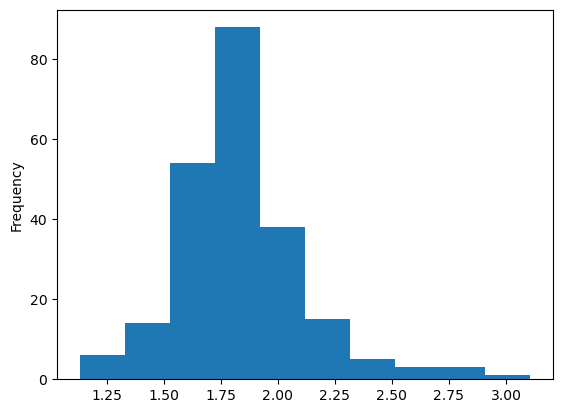

In [162]:
test['total_score'].plot.hist()

### Compare with real results

In [169]:
test = test.merge(tps_db[['id', 'most_unique_product_name', 'most_unique_product_count']], how='left', on='id', suffixes=[None, '_real'])

In [213]:
test['most_unique_product_count_real_log'] = np.log(test['most_unique_product_count_real'])

In [214]:
test_sorted = test.sort_values(by='total_score', ascending=False)

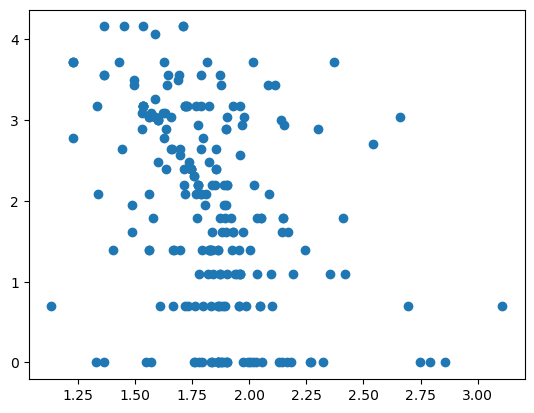

In [215]:
plt.scatter(test_sorted['total_score'], test_sorted['most_unique_product_count_real_log'])

## Spearman's rank correlation

In [173]:
test[['total_score','most_unique_product_count_real']].corr(method='spearman')

,total_score,most_unique_product_count_real
total_score,1.000000,-0.443616
most_unique_product_count_real,-0.443616,1.000000


In [176]:
test.shape[0]/10

22.7

In [181]:
test_sorted.columns

Index(['id', 'tax_id', 'lineage', 'superkingdom', 'unchar_phylum',
       'unchar_class', 'unchar_order', 'unchar_family', 'unchar_genus',
       'unchar_species', 'tax_score', 'size', 'log_size', 'norm_log_size',
       'cluster', 'represented_by', 'total_size', 'n_characterized',
       'unchar_perc', 'log_total_size', 'log_norm_total_size', 'cluster_score',
       'most_unique_product_count', 'product_score', 'total_score',
       'most_unique_product_name', 'most_unique_product_count_real'],
      dtype='object')

In [177]:
test_sorted.head(23)

,id,tax_id,lineage,superkingdom,unchar_phylum,unchar_class,unchar_order,unchar_family,unchar_genus,unchar_species,...,n_characterized,unchar_perc,log_total_size,log_norm_total_size,cluster_score,most_unique_product_count,product_score,total_score,most_unique_product_name,most_unique_product_count_real
92,A9FZ87,56,"{'species': 'Sorangium cellulosum', 'genus': '...",Bacteria,True,None,True,True,True,True,...,26,0.997664,9.317220,0.763771,0.880718,4,0.952381,3.107167,(+)-eremophilene,2
90,ATN39899.1,1204,"{'species': 'Scytonema sp.', 'genus': 'Scytone...",Bacteria,False,False,False,True,True,True,...,0,1.000000,6.165418,0.505405,0.752703,2,0.984127,2.855271,merosterolic acid A,1
97,A9GK58,56,"{'species': 'Sorangium cellulosum', 'genus': '...",Bacteria,True,None,True,True,True,True,...,26,0.997664,9.317220,0.763771,0.880718,20,0.698413,2.791253,(−)-10-epi-cubebol,1
88,A0A343W969,460024,"{'species': 'Murgantia histrionica', 'genus': ...",Eukaryota,False,False,False,False,True,True,...,1,0.952381,3.044522,0.249572,0.600977,1,1.000000,2.746598,"(1S,6S,7R)-sesquipiperitol\n",1
192,P21684,553,"{'species': 'Pantoea ananatis', 'genus': 'Pant...",Bacteria,False,False,False,False,False,True,...,0,1.000000,11.028255,0.904032,0.952016,21,0.682540,2.695589,phytoene,2
186,A5A8G0,3218,"{'species': 'Physcomitrium patens', 'genus': '...",Eukaryota,False,False,True,True,True,True,...,114,0.989933,9.334680,0.765203,0.877568,3,0.968254,2.657944,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat...",21
179,P37294,1143,"{'species': 'Synechocystis sp.', 'genus': 'Syn...",Bacteria,False,False,False,True,True,True,...,10,0.999774,10.699688,0.877098,0.938436,3,0.968254,2.542842,15-cis-phytoene,15
208,A0A1J0CQ90,41848,"{'species': 'Scapania nemorea', 'genus': 'Scap...",Eukaryota,False,False,False,True,True,True,...,1,0.984127,4.143135,0.339630,0.661879,1,1.000000,2.418797,bicycloelemene,3
81,A0A0C3FBR2,80663,"{'species': 'Piloderma croceum', 'genus': 'Pil...",Eukaryota,False,False,True,True,True,True,...,46,0.981452,7.816014,0.640711,0.811081,1,1.000000,2.411081,viridiflorene,6
158,G7LHE5,3880,"{'species': 'Medicago truncatula', 'genus': 'M...",Eukaryota,False,False,False,False,False,False,...,93,0.988466,8.995041,0.737361,0.862913,1,1.000000,2.370359,β-amyrin,41


In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<module 'matplotlib.pyplot' from 'C:\\Users\\terca\\anaconda3\\envs\\esm_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

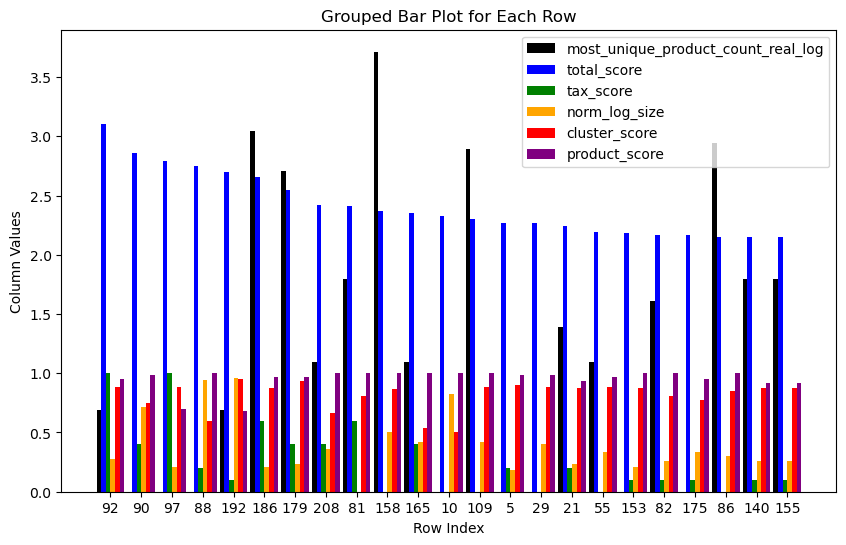

In [217]:
test_sorted.head(23)

# Set the number of columns and colors
num_columns = 6
colors = ['black','blue', 'green', 'orange', 'red', 'purple']
columns = ['most_unique_product_count_real_log','total_score','tax_score','norm_log_size','cluster_score','product_score']

# Set the bar width
bar_width = 0.15  # Adjust this value according to your preference

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, (col, color) in enumerate(zip(columns, colors)):
    positions = np.arange(len(test_sorted.head(23))) + i * bar_width
    ax.bar(positions, test_sorted.head(23)[col], width=bar_width, color=color, label=col)

# Add labels and legend
ax.set_xlabel('Row Index')
ax.set_ylabel('Column Values')
ax.set_title('Grouped Bar Plot for Each Row')
ax.set_xticks(np.arange(len(test_sorted.head(23))) + (bar_width * (num_columns - 1)) / 2)
ax.set_xticklabels(test_sorted.head(23).index)
ax.legend()

# Show the plot
plt

In [188]:
import seaborn as sns

<Axes: >

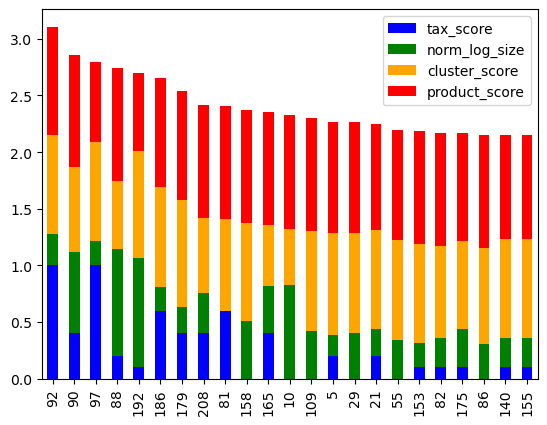

In [192]:
test_sorted.head(23)[['tax_score','norm_log_size','cluster_score','product_score']].plot(kind='bar', stacked=True, color=['blue', 'green', 'orange', 'red'])

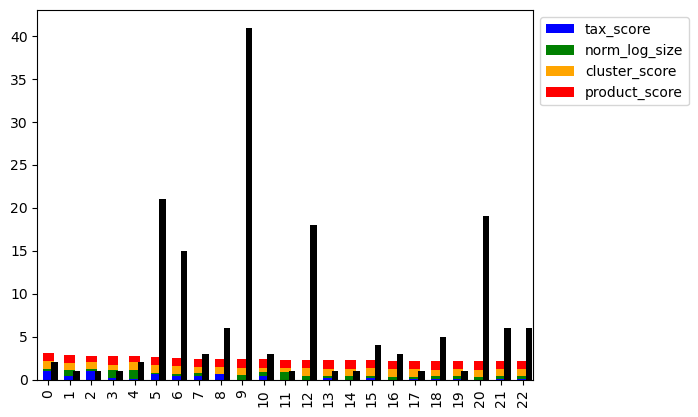

In [198]:
df = test_sorted.head(23).reset_index()

# Plotting
fig, ax = plt.subplots()

# Plotting the stacked bars
df[['tax_score', 'norm_log_size', 'cluster_score', 'product_score']].plot(
    kind='bar', stacked=True, color=['blue', 'green', 'orange', 'red'], ax=ax
)

# Adding the additional 'total_score' bars next to each stacked bar
total_score_bars = ax.bar(
    df.index + 0.3,  # Adjust the x-axis position to place it next to the stacked bars
    df['most_unique_product_count_real'],
    width=0.3,  # Adjust the width of the 'total_score' bars
    color='black'  # Choose a color for the 'total_score' bars
)

# Adding legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

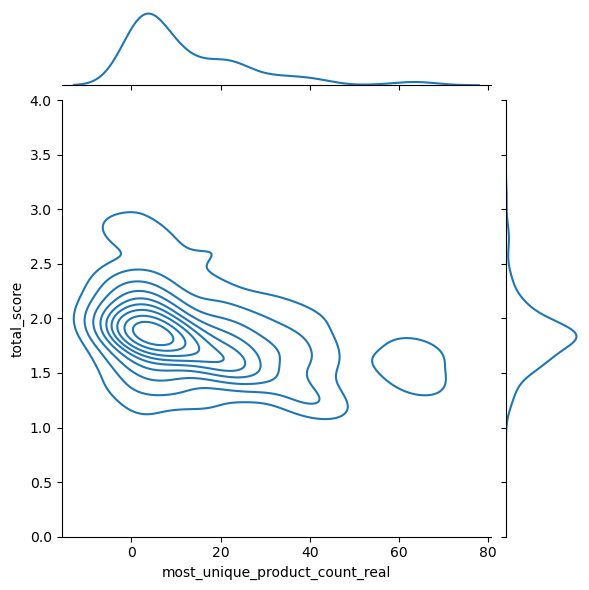

In [235]:
sns.jointplot(
    data=test,
    x="most_unique_product_count_real", y="total_score",
    kind="kde",
    ylim=(0,4)
)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

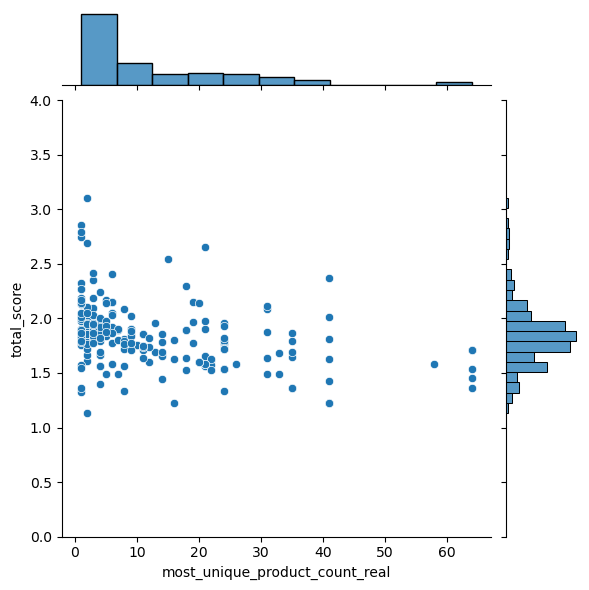

In [236]:
sns.jointplot(
    data=test,
    x="most_unique_product_count_real", y="total_score",
    ylim=(0,4),
    kind="scatter",
)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

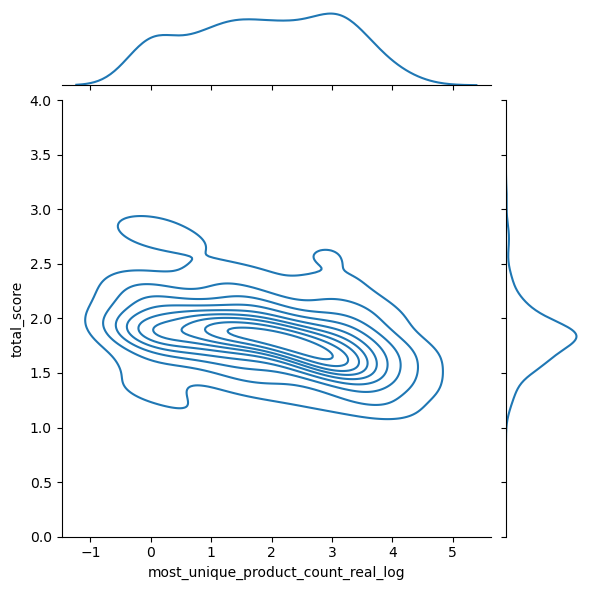

In [237]:
sns.jointplot(
    data=test,
    x="most_unique_product_count_real_log", y="total_score",
    kind="kde",
    ylim=(0,4)
)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

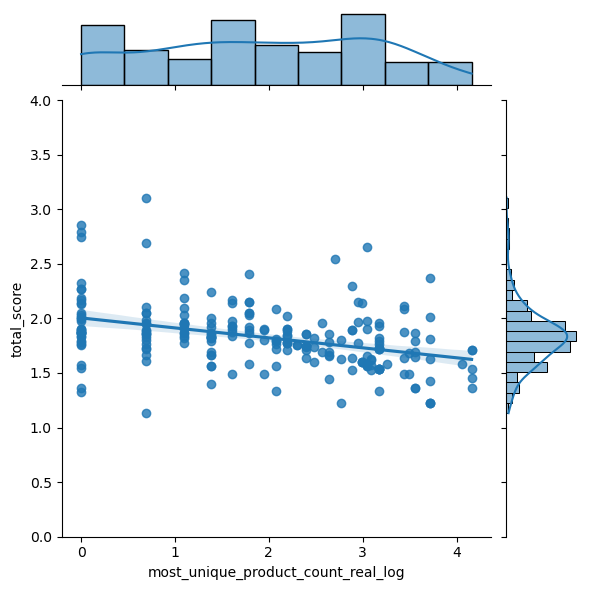

In [238]:
sns.jointplot(
    data=test,
    x="most_unique_product_count_real_log", y="total_score",
    kind="reg",
    ylim=(0,4)
)

C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

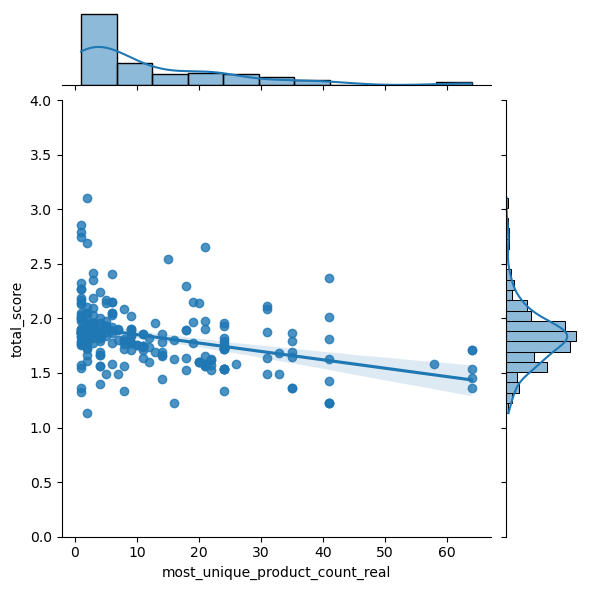

In [239]:
sns.jointplot(
    data=test,
    x="most_unique_product_count_real", y="total_score",
    kind="reg",
    ylim=(0,4)
)

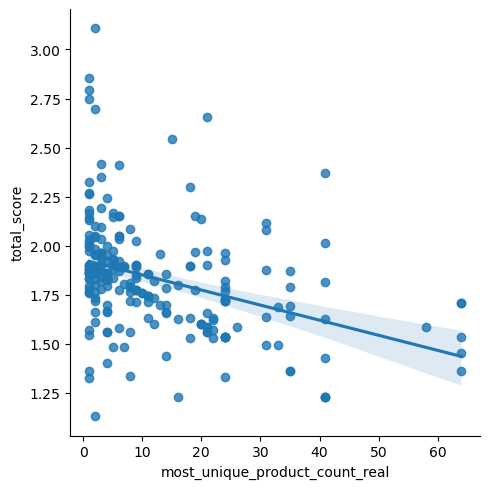

In [221]:
sns.lmplot(data=test, x="most_unique_product_count_real", y="total_score")

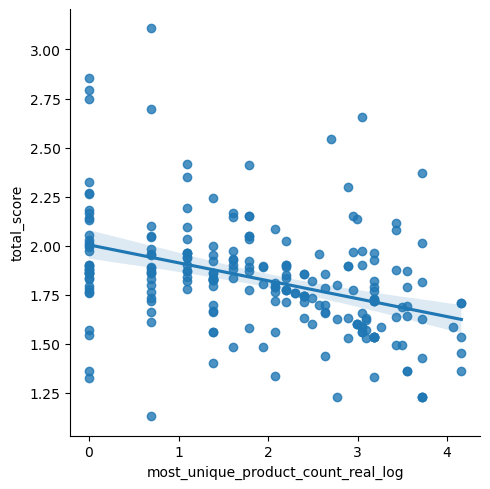

In [220]:
sns.lmplot(data=test, x="most_unique_product_count_real_log", y="total_score")

In [227]:
test[columns]

,most_unique_product_count_real_log,total_score,tax_score,norm_log_size,cluster_score,product_score
0,2.397895,1.712191,0.0,0.000000,0.902667,0.809524
1,3.091042,1.620936,0.0,0.091356,0.862913,0.666667
2,0.693147,1.609186,0.0,0.091356,0.533703,0.984127
3,1.098612,1.960950,0.0,0.091356,0.901340,0.968254
4,2.944439,1.774533,0.0,0.212122,0.848125,0.714286
...,...,...,...,...,...,...
222,0.000000,1.862913,0.0,0.000000,0.862913,1.000000
223,3.044522,1.902667,0.0,0.000000,0.902667,1.000000
224,3.091042,1.529580,0.0,0.000000,0.862913,0.666667
225,3.178054,1.536260,0.0,0.000000,0.901340,0.634921


C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\terca\anaconda3\envs\esm_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

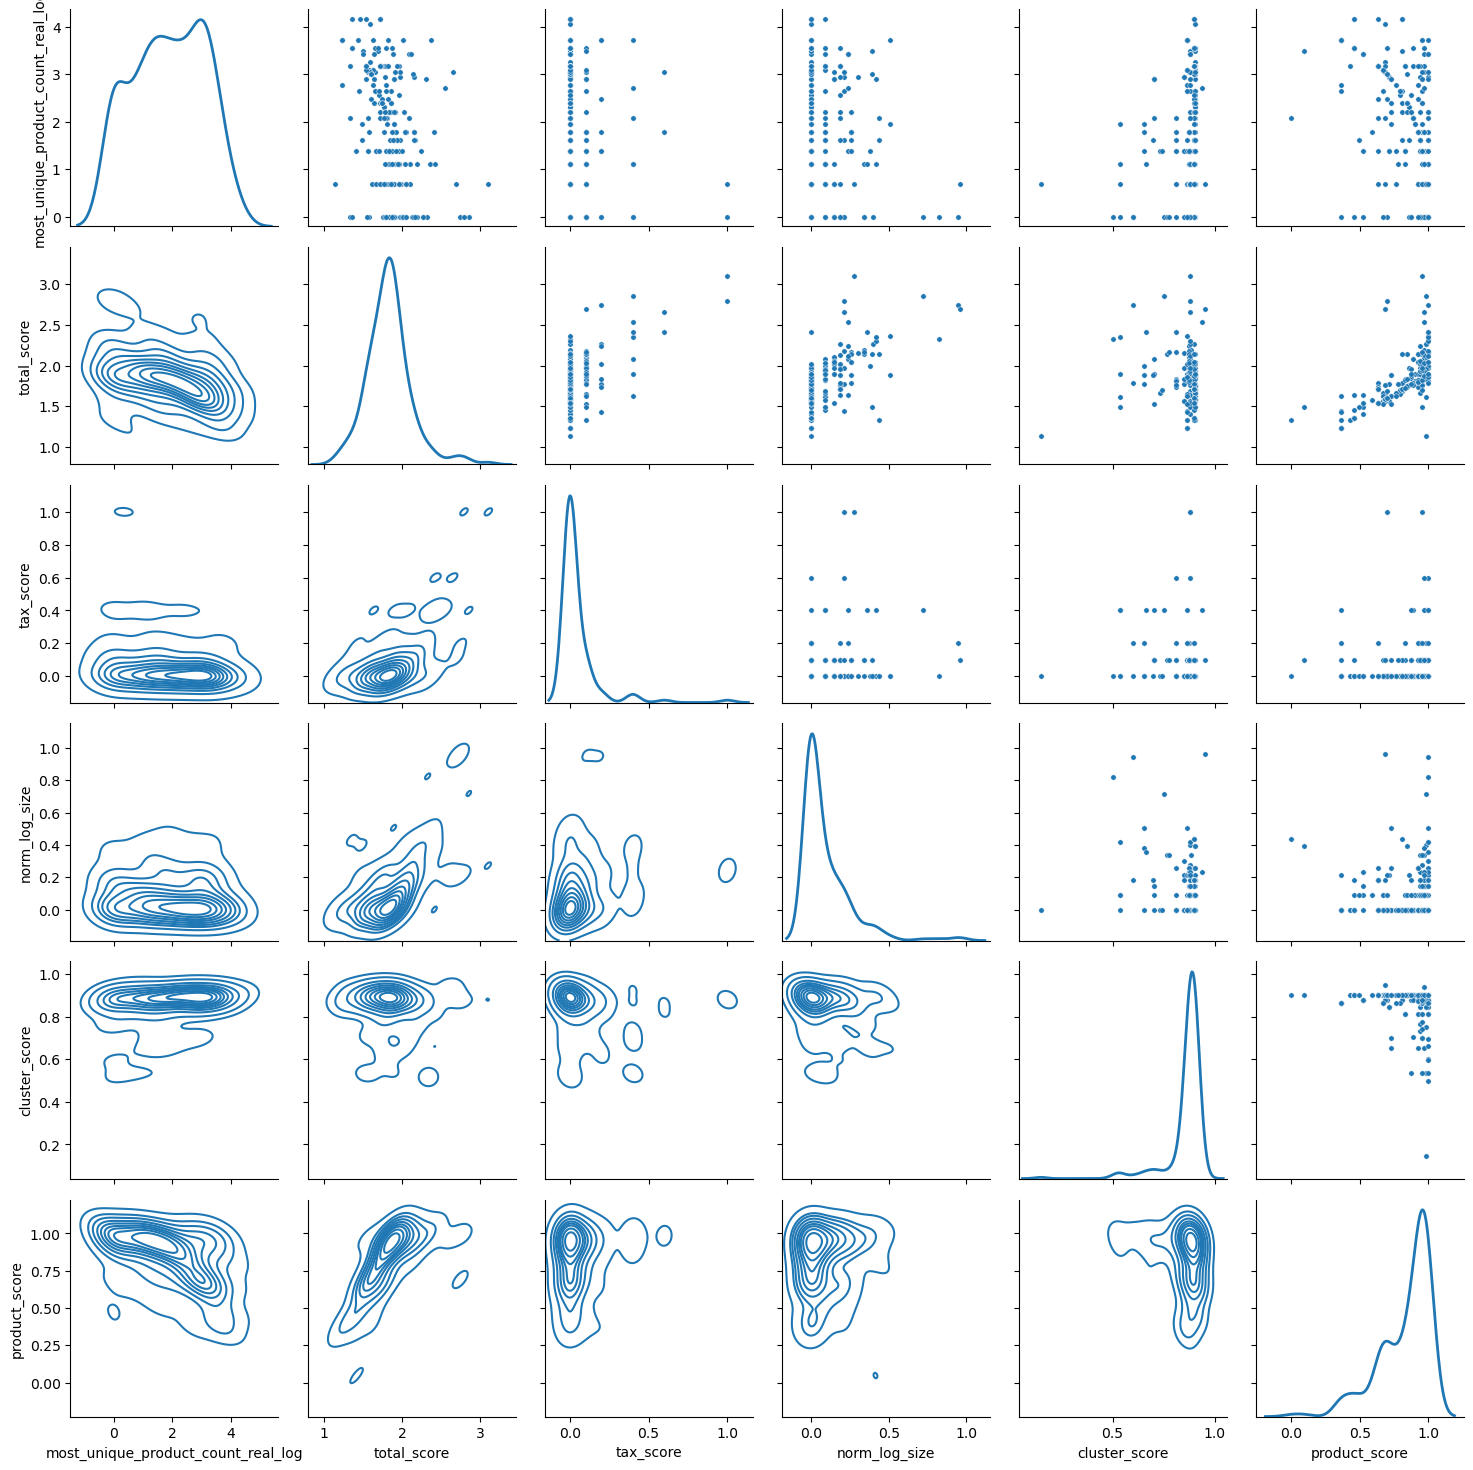

In [229]:
g = sns.PairGrid(test[columns], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)